In [1]:
import pandas as pd
from numpy import arange, asarray, linspace, cumsum, percentile, histogram
from numpy import array, around, trapz, mean, std
from numpy.random import normal
import scipy
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
# Load data and select first column
from matplotlib.pyplot import subplots, scatter, xlabel, ylabel, axis, figure

from sklearn import datasets
from sklearn.preprocessing import StandardScaler


# Justification of Clustering

Clustering assumes that there is no prior knowledge about the existence of more than one categories of data within a single dataset. I such knowledge exists it would point to supervised learning.

The goal of the clustering (grouping, automated labelling) is to obtain more than one predicted labels (or label probabilities) for samples based on some distinction that is data-driven (rather than knowledge driven). So you only apply it when you have reasons to suspect that more than one labels are justified to group your data. 

Before we apply a specific algorithm to obtain labels we need to be aware that the clustering algorithms may yield plausible results for just about any dataset. Also we need to take into account that different algorithms search according to different criteria and results may differ depending on the algorithm chosen. So we have to answer two fundamental questions:

1. Is it justified to do clustering? 
2. Which algorithm should be used?) 

We use synthetic data to get answers to these questions. 

The steps we follow are:

We create data that should have a single label. Specifically we start with data that follow a single probability density distribution and generate a discrete histogram as we would do with recorded data. 

Then we fit different probability density functions to these test data and check the goodness of fit. Based on a quantitative criterion we decide for one distribution. Finally, we check whether the obtained fit justifies the assumption of a single label (cluster). Only if we can reject thishypothesis will we proceed to do a clustering. Incidentally, the type of distribution that best fits the data is used as a criterion to pick a clustering algorithm.

When the clustering is finished we create data from the two distinct distributions that, according to the unsupervised learning, fit the data best. Then we can separate the data according to the labels and check the fit of the individual distributions. If we have improved the p-value, then this serves as assurance that the clustering was justified, i.e. the data warranted a grouping into two different groups. 

In this lesson, we analyse one dataset and conclude that clustering is justified. 

We start by creating data drawn from a single Gaussian distribution and plot their histogram. Before we apply any analysis, we standardise the data set to mean 0, variance 1. We plot diagrams for the articifial data and their standardised form. Note the difference in horizontal scale. 

Distribution fitting to data, based on the tutorial by Michael Allen:
https://pythonhealthcare.org/2018/05/03/81-distribution-fitting-to-data/


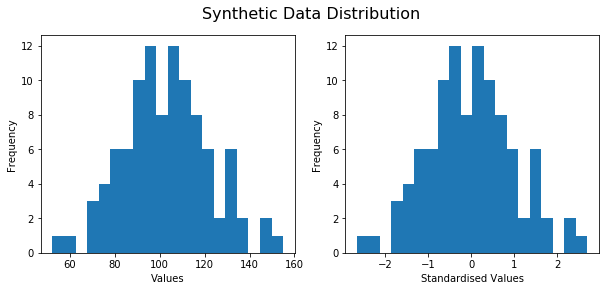

In [15]:
n = 100

data_n = normal(100, 20, n)
size = len(data_n)
x = arange(len(data_n))

sc=StandardScaler() 

temp = data_n.reshape (-1,1)

sc.fit(temp)
data_n_st =sc.transform(temp)
data_n_st = data_n_st.flatten()
del temp

fig, ax = subplots(figsize=(10,4), ncols=2)


ax[0].hist(data_n, bins=20)
ax[1].hist(data_n_st, bins=20);

ax[0].set_xlabel('Values')
ax[0].set_ylabel('Frequency')
ax[1].set_xlabel('Standardised Values')
ax[1].set_ylabel('Frequency')

fig.suptitle('Synthetic Data Distribution', fontsize=16);


When starting with a not too small number of samples we find a plausible histogram reflecting the underlying Gaussian distribution.


Now we fit three different continuous distributions to the data: the exponential distribution; the uniform distribution; and the normal distribution. This may seem trivial in the first round as we know the result already. However, we want to use the same procedure later for data that we suspect to contain multiple labels ans where we cannot be sure of the outcome. We use to two measures to qunatify the quality of fit: 

1. the chi-square statistics, which is the sum of the squared distances of the data from the fitted distribution. The larger it is, the worse the fit. Note that this value is not normalised.
2. The p-value for the fit which is the probability that the data are drawn from that specific distribution. The larger it is the better the fit. It is 1 (100%) if the fit is perfect.


In [6]:
# Set list of distributions to test
# See https://docs.scipy.org/doc/scipy/reference/stats.html for more

# Turn off code warnings (this is not recommended for routine use)
import warnings
warnings.filterwarnings("ignore")

# Set up list of candidate distributions to use
# See https://docs.scipy.org/doc/scipy/reference/stats.html for more

dist_names = [
#               'beta',
              'expon',
#               'gamma',
#               'lognorm',
              'norm',
#               'pearson3',
#               'triang',
              'uniform',
#               'weibull_min', 
#               'weibull_max'
             ]

# Set up empty lists to stroe results
chi_square = []
p_values = []

# Set up 50 bins for chi-square test
# Observed data will be approximately evenly distributed across all bins
number_bins = 51
percentile_bins = linspace(0, 100, number_bins)
percentile_cutoffs = percentile(data_n_st, percentile_bins)
observed_frequency, bins = (histogram(data_n_st, bins=percentile_cutoffs))
cum_observed_frequency = cumsum(observed_frequency)

# Loop through candidate distributions

for distribution in dist_names:
    # Set up distribution and get fitted distribution parameters
    dist = getattr(scipy.stats, distribution)
    param = dist.fit(data_n_st)
    
    # Obtain the KS test P statistic, round it to 5 decimal places
    p = scipy.stats.kstest(data_n_st, distribution, args=param)[1]
    p = around(p, 5)
    p_values.append(p)    
    
    # Get expected counts in percentile bins
    # This is based on a 'cumulative distribution function' (cdf)
    cdf_fitted = dist.cdf(percentile_cutoffs, *param[:-2], loc=param[-2], 
                          scale=param[-1])
    expected_frequency = []
    for bin in range(len(percentile_bins)-1):
        expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
        expected_frequency.append(expected_cdf_area)
    
    # calculate chi-squared
    expected_frequency = array(expected_frequency) * size
    cum_expected_frequency = cumsum(expected_frequency)
    ss = sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
    chi_square.append(ss)
        
# Collate results and sort by goodness of fit (best at top)

results = pd.DataFrame()
results['Distribution'] = dist_names
results['chi_square'] = chi_square
results['p_value'] = p_values
results.sort_values(['chi_square'], inplace=True)
    
# Report results

print ('\nDistributions sorted by goodness of fit:')
print ('----------------------------------------')
print (results)



Distributions sorted by goodness of fit:
----------------------------------------
  Distribution   chi_square  p_value
1         norm     5.844148  0.92542
2      uniform   519.079487  0.00153
0        expon  1624.527913  0.00000


The result shows: 

- Low chi-square value and large p-value for the normal distribution
- High chi-square values and zero p-value for the uniform and exponential distribution.

This indicates that we have reasons to approximate our data set with a normal distribution. 

We can now use the parameters of the above fitted distributions to plot the continuous function on top of the data.


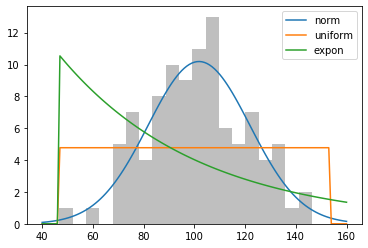

In [8]:
# Divide the observed data into bins for plotting (this can be changed)
number_of_bins = 20
bin_cutoffs = linspace(percentile(data_n, 0), percentile(data_n, 99),number_of_bins)

# Create the plot
fig, ax = subplots()

h = ax.hist(data_n, bins = bin_cutoffs, color='0.75')
lims = ax.get_xlim()

# Get the top three distributions from the previous phase
number_distributions_to_plot = 3
dist_names = results['Distribution'].iloc[0:number_distributions_to_plot]

# Create an empty list to stroe fitted distribution parameters
parameters = []


# Loop through the distributions ot get line fit and parameters

for dist_name in dist_names:
    # Set up distribution and store distribution parameters
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(data_n)
    parameters.append(param)

    x = arange(40, 161)

    # Get line for each distribution (and scale to match observed data)
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1])
#    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1])
    scale_pdf = trapz (h[0], h[1][:-1]) / trapz (pdf_fitted, x)
    pdf_fitted *= scale_pdf
    
    # Add the line to the plot
    ax.plot(x, pdf_fitted, label=dist_name)

    # Set the plot x axis to contain 99% of the data
    # This can be removed, but sometimes outlier data makes the plot less clear
#    ax.xlim(0, percentile(data_n,99))



# Add legend and display plot
ax.legend();
# plt.show()


This graph confirms visually that the normal distribution approximates the data well whereas exponential and uniform distribution are not good assumptions. 

Note that there are a large number of distributions to choose from and not all will give such clear cut distinctions.

See https://docs.scipy.org/doc/scipy/reference/stats.html for more.

Now let us import one of our data sets and and look at the distribution before applying the same fitting.

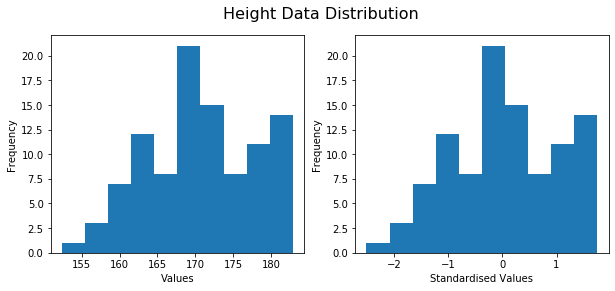

In [16]:
from pandas import read_csv

df = read_csv("../data/patients.csv") 

df['Weight'] = 0.45*df['Weight']
df['Height'] = 2.54*df['Height']

y_df = df['Height']
data = y_df.to_numpy()

size = len(data)

sc=StandardScaler() 
yy = data.reshape (-1,1)
sc.fit(yy)
data_st =sc.transform(yy)
data_st = data_st.flatten()
del yy

fig, ax = subplots(figsize=(10,4), ncols=2)

ax[0].hist(data, bins=10)
ax[1].hist(data_st, bins=10)

ax[0].set_xlabel('Values')
ax[0].set_ylabel('Frequency')
ax[1].set_xlabel('Standardised Values')
ax[1].set_ylabel('Frequency')

fig.suptitle('Height Data Distribution', fontsize=16);


Now let us repeat the fitting of our three distributions:

In [18]:
# Set list of distributions to test
# See https://docs.scipy.org/doc/scipy/reference/stats.html for more

# Turn off code warnings (this is not recommended for routine use)
import warnings
warnings.filterwarnings("ignore")

# Set up list of candidate distributions to use
# See https://docs.scipy.org/doc/scipy/reference/stats.html for more

dist_names = [
#               'beta',
              'expon',
#               'gamma',
#               'lognorm',
              'norm',
#               'pearson3',
#               'triang',
              'uniform',
#               'weibull_min', 
#               'weibull_max'
             ]

# Set up empty lists to store results
chi_square = []
p_values = []

# Set up bins for chi-square test
# Observed data will be approximately evenly distributed across all bins
no_bins = 31
percentile_bins = linspace(0, 100, no_bins)
percentile_cutoffs = percentile(data_st, percentile_bins)
observed_frequency, bins = (histogram(data_st, bins=percentile_cutoffs))
cum_observed_frequency = cumsum(observed_frequency)

# Loop through candidate distributions

for distribution in dist_names:
    # Set up distribution and get fitted distribution parameters
    dist = getattr(scipy.stats, distribution)
    param = dist.fit(data_st)
    
    # Obtain the KS test P statistic, round it to 5 decimal places
    p = scipy.stats.kstest(data_st, distribution, args=param)[1]
    p = around(p, 5)
    p_values.append(p)    
    
    # Get expected counts in percentile bins
    # This is based on a 'cumulative distribution function' (cdf)
    cdf_fitted = dist.cdf(percentile_cutoffs, *param[:-2], loc=param[-2], 
                          scale=param[-1])
    expected_frequency = []
    for bin in range(len(percentile_bins)-1):
        expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
        expected_frequency.append(expected_cdf_area)
    
    # calculate chi-squared
    expected_frequency = array(expected_frequency) * size
    cum_expected_frequency = cumsum(expected_frequency)
    ss = sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
    chi_square.append(ss)
        
# Collate results and sort by goodness of fit (best at top)

results = pd.DataFrame()
results['Distribution'] = dist_names
results['chi_square'] = chi_square
results['p_value'] = p_values
results.sort_values(['chi_square'], inplace=True)
    
# Report results

print ('\nDistributions sorted by goodness of fit:')
print ('----------------------------------------')
print (results)

# # Store distribution parameters in a dataframe (this could also be saved)
# dist_parameters = pd.DataFrame()
# dist_parameters['Distribution'] = (
#         results['Distribution'].iloc[0:number_distributions_to_plot])
# dist_parameters['Distribution parameters'] = parameters

# # Print parameter results
# print ('\nDistribution parameters:')
# print ('------------------------')

# for index, row in dist_parameters.iterrows():
#     print ('\nDistribution:', row[0])
#     print ('Parameters:', row[1] )


Distributions sorted by goodness of fit:
----------------------------------------
  Distribution   chi_square  p_value
1         norm    22.253261  0.17166
2      uniform   534.873841  0.00007
0        expon  1120.140011  0.00000


Note that the quality of both measures has dropped for the normal distribution.

Let us check the fit:

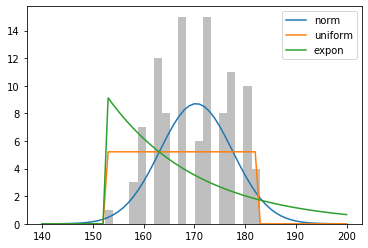

In [19]:
# Divide the observed data into bins for plotting (this can be changed)
number_of_bins = 20
bin_cutoffs = linspace(percentile(data, 0), percentile(data, 99),number_of_bins)

# Create the plot
fig, ax = subplots()

h = ax.hist(data, bins = bin_cutoffs, color='0.75')
lims = ax.get_xlim()

# Get the top three distributions from the previous phase
number_distributions_to_plot = 3
dist_names = results['Distribution'].iloc[0:number_distributions_to_plot]

# Create an empty list to store fitted distribution parameters
parameters = []

# Loop through the distributions ot get line fit and parameters

for dist_name in dist_names:
    # Set up distribution and store distribution parameters
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(data)
    parameters.append(param)

    x = arange(140, 201)

    # Get line for each distribution (and scale to match observed data)
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1])
#    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1])
    scale_pdf = trapz (h[0], h[1][:-1]) / trapz (pdf_fitted, x)
    pdf_fitted *= scale_pdf
    
    # Add the line to the plot
    ax.plot(x, pdf_fitted, label=dist_name)

    # Set the plot x axis to contain 99% of the data
    # This can be removed, but sometimes outlier data makes the plot less clear
#    ax.xlim(0, percentile(data_n,99))


# Add legend and display plot
ax.legend()
# plt.show()


Things are now less clear. It could be that the fit is OK but that the number of samples is too small; or it could be that there is actually more than one distributions drawn in a single graph. In the latter case, unsupervised machine learning might be justified. 

To improve our test, we now create a more tailored synthetic data set. Normally distributed data are drawn from a Gaussian distribution with specified mean and standard deviation (or variance). We can adjust these parameters based on the mean and standard deviation of our data set.

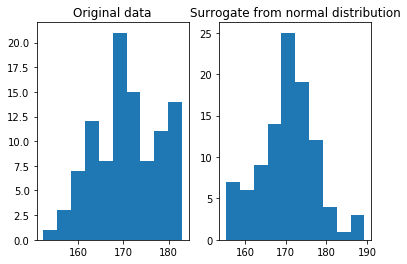

In [21]:
no_data_points = len(data)
data_mean = mean(data)
data_std = std(data)

data_n = normal(data_mean, data_std, no_data_points)

sc=StandardScaler() 

temp = data_n.reshape (-1,1)
sc.fit(temp)
data_n_st =sc.transform(temp)
data_n_st = data_n_st.flatten()
del temp

fig, ax = subplots(ncols=2)

ax[0].hist(data, bins=10)
ax[1].hist(data_n, bins=10);
ax[0].set_title('Original data')
ax[1].set_title('Surrogate from normal distribution');


# Function to fit normal distributions

In [22]:
def fit_norm_distributions(data, no_bins):

    size = len(data)

    # Set list of distributions to test
    # See https://docs.scipy.org/doc/scipy/reference/stats.html for more

    # Turn off code warnings (this is not recommended for routine use)
    import warnings
    warnings.filterwarnings("ignore")

    # Set up list of candidate distributions to use
    # See https://docs.scipy.org/doc/scipy/reference/stats.html for more

    dist_names = [
    #               'beta',
    #               'expon',
    #               'gamma',
    #               'lognorm',
                  'norm',
    #               'pearson3',
    #               'triang',
    #               'uniform',
    #               'weibull_min', 
    #               'weibull_max'
                 ]

    # Set up empty lists to store results
    chi_square = []
    p_values = []

    # Set up bins for chi-square test
    # Observed data will be approximately evenly distributed across all bins
    percentile_bins = linspace(0, 100, no_bins)
    percentile_cutoffs = percentile(data, percentile_bins)
    observed_frequency, bins = (histogram(data, bins=percentile_cutoffs))
    cum_observed_frequency = cumsum(observed_frequency)

    # Loop through candidate distributions

    for distribution in dist_names:
        # Set up distribution and get fitted distribution parameters
        dist = getattr(scipy.stats, distribution)
        param = dist.fit(data)

        # Obtain the KS test P statistic, round it to 5 decimal places
        p = scipy.stats.kstest(data, distribution, args=param)[1]
        p = around(p, 5)
        p_values.append(p)    

        # Get expected counts in percentile bins
        # This is based on a 'cumulative distrubution function' (cdf)
        cdf_fitted = dist.cdf(percentile_cutoffs, *param[:-2], loc=param[-2], 
                              scale=param[-1])
        expected_frequency = []
        for bin in range(len(percentile_bins)-1):
            expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
            expected_frequency.append(expected_cdf_area)

        # calculate chi-squared
        expected_frequency = array(expected_frequency) * size
        cum_expected_frequency = cumsum(expected_frequency)
        ss = sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
        chi_square.append(ss)

    # Collate results and sort by goodness of fit (best at top)

    results = pd.DataFrame()
    results['Distribution'] = dist_names
    results['chi_square'] = chi_square
    results['p_value'] = p_values
    results.sort_values(['chi_square'], inplace=True)
    
    return results

    # Report results

    # # Store distribution parameters in a dataframe (this could also be saved)
    # dist_parameters = pd.DataFrame()
    # dist_parameters['Distribution'] = (
    #         results['Distribution'].iloc[0:number_distributions_to_plot])
    # dist_parameters['Distribution parameters'] = parameters

    # # Print parameter results
    # print ('\nDistribution parameters:')
    # print ('------------------------')

    # for index, row in dist_parameters.iterrows():
    #     print ('\nDistribution:', row[0])
    #     print ('Parameters:', row[1] )


In [23]:
# Results for data:

no_bins = 31

results = fit_norm_distributions(data_st, no_bins)
p_value_data = results['p_value'][0]

print ('----------------------------------------')
print ('p-value of data: ', p_value_data)


----------------------------------------
p-value of data:  0.17166


   p-values of data (red) and surrogates (blue): 


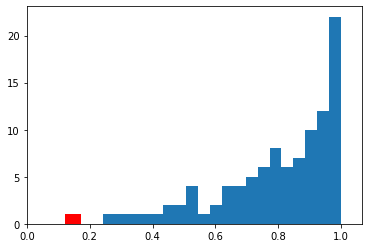

In [26]:
# Distribution of surrogate data

no_surrogates = 100

results_p = list()

for ind in arange(no_surrogates):

    data_n = normal(data_mean, data_std, no_data_points)
    sc=StandardScaler()
    temp = data_n.reshape (-1,1)
    sc.fit(temp)
    data_n_st =sc.transform(temp)
    data_n_st = data_n_st.flatten()
    del temp
    
    result = fit_norm_distributions(data_n_st, 31)
    results_p.append(result['p_value'][0])
#     print (': \nDistributions of data sorted by goodness of fit:')
#     print ('----------------------------------------')

print('   p-values of data (red) and surrogates (blue): ')
#  print ('\n', results_p)

fig, ax = subplots()

ax.hist(results_p, bins=20);
ax.hist(p_value_data, bins=20, color='r');
ax.set_xlim(xmin=0);

The p-value for the data is much lower than the p-values of the surrogates. This plot suggests that while the data can be fitted with a normal distribution, they are not compatible with a single distribution. Note, however, that even the samples drawn from a normal distribution can have p-values that are nearly as low as the data. They are just not frequent. Only about a third of the surrogate data produced a distribution that is 100% compatible with the normal distribution. 

Now have done two checks: first we quantified which distribution might be used to describe the data. A normal distribution looked like an OK fit. Second we analysed whether tha data are compatible with a single normal distribution. It appears that a single normal distribution is not a good interpretation of the data.


Our conclusion is that we can try to model the data as coming from more than one source while the assumption of normally distributed sources might be valid. 

One clustering approach that suggests itself frmo these observations is the Gaussian Mixed Models clustering. We assume that there are data mixed frmo ore than one normally distributed groups in the full data set. The clustering will provide us with suggestions to separate the groups. 